## Import packages and define paths

In [1]:
import tensorflow as tf
from nptyping import NDArray
import cv2 as cv
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math

template_dir = '../data'
image_path = '../data/KITTI/testing/image_2/IMG_1517_aug_4.jpg'

## Read image as grayscale image and resize them

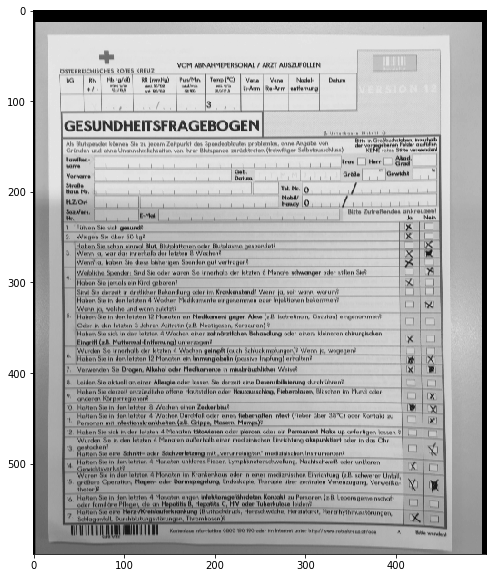

In [2]:
input_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
resize_input_image = cv.resize(input_image, (500, 600))
plt.figure(figsize=(15,10))
plt.imshow(resize_input_image, cmap='gray', vmin=0, vmax=255)

## Read each template, resize and unwarp the image based on each template

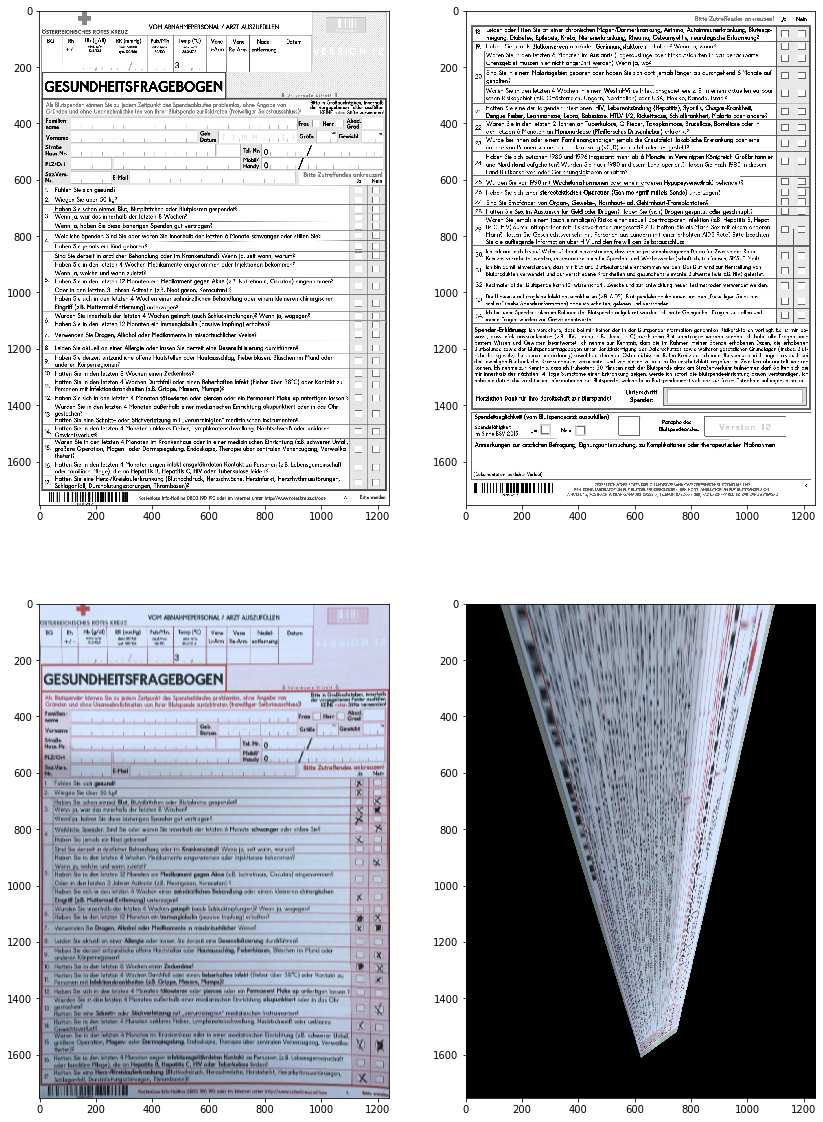

In [3]:
def map_feature(image, template, ratio_thresh):
    akaze = cv.AKAZE_create()
    key_points, descriptors = akaze.detectAndCompute(template, None)
    key_points2, descriptors2 = akaze.detectAndCompute(image, None)
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
    knn_matches = matcher.knnMatch(descriptors, descriptors2, 2)
    good_matches = [m for m, n in knn_matches if m.distance < ratio_thresh * n.distance]
    img_matches = np.empty((max(template.shape[0], image.shape[0]), template.shape[1]+image.shape[1], 3), dtype=np.uint8)
    cv.drawMatches(template, key_points, image, key_points2, good_matches, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    obj = np.empty((len(good_matches), 2), dtype=np.float32)
    scene = np.empty((len(good_matches), 2), dtype=np.float32)
    for i in range(len(good_matches)):
        obj[i, 0] = key_points[good_matches[i].queryIdx].pt[0]
        obj[i, 1] = key_points[good_matches[i].queryIdx].pt[1]
        scene[i, 0] = key_points2[good_matches[i].trainIdx].pt[0]
        scene[i, 1] = key_points2[good_matches[i].trainIdx].pt[1]
    H, _ = cv.findHomography(scene, obj, cv.RANSAC)
    return H

#    cv.warpPerspective(src=image, M=H, dsize=template.shape[1::-1])

template_path_list = list(Path(template_dir).glob('**/template*'))
fig, axs = plt.subplots(math.ceil(len(template_path_list)/2)*2, 2, figsize=(14,20))

for idx, template_path in enumerate(template_path_list):
    row_idx = math.floor(idx/2)
    col_idx = idx % 2
    template_image = cv.imread(str(template_path), cv.IMREAD_GRAYSCALE) 
    H = map_feature(resize_input_image, template_image, .75)
    unwarpped_image = cv.warpPerspective(src=cv.resize(cv.imread(image_path), (500, 600)), M=H, dsize=template_image.shape[1::-1])
    cv.imwrite('unwarpped_'+template_path.name, unwarpped_image)
    axs[row_idx*2, col_idx].imshow(cv.cvtColor(template_image, cv.COLOR_BGR2RGB))
    axs[row_idx*2+1, col_idx].imshow(cv.cvtColor(unwarpped_image, cv.COLOR_BGR2RGB))

## Convert unwarpped image to lab and do adaptive gaussian thresheld

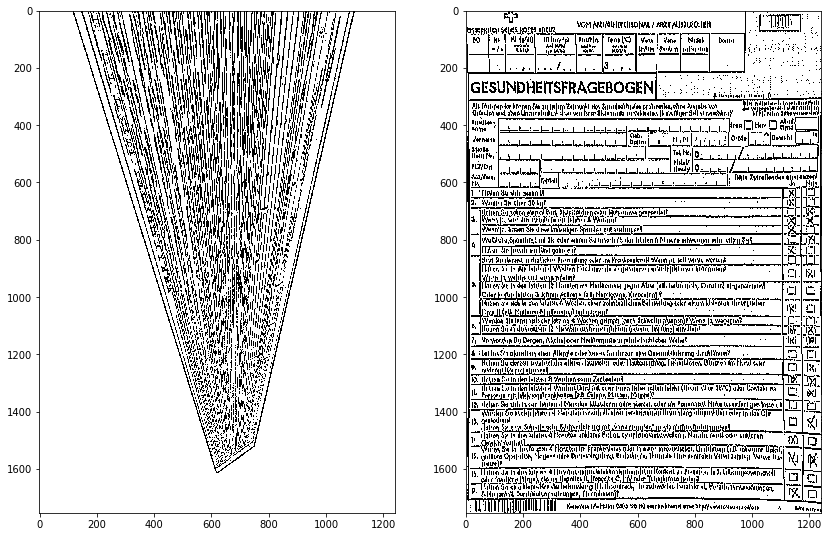

In [4]:
import sys
unwarpped_path_list = list(Path('./').glob('unwarpped*g'))
fig, axs = plt.subplots(math.ceil(len(unwarpped_path_list)/2), 2, figsize=(14,10))
for i, unwarpped_path in enumerate(unwarpped_path_list):
    unwarpped_image = cv.cvtColor(cv.imread(str(unwarpped_path)),cv.COLOR_BGR2Lab)
    #axs[1, i].imshow(cv.cvtColor(unwarpped_image, cv.COLOR_Lab2RGB))    
    unwarpped_image_light = unwarpped_image[:,:,0].astype(np.float32)
    #blured_img = cv.GaussianBlur(unwarpped_image_light, (501, 501), 0).astype(np.float32)
    #axs[0, i].imshow(blured_img, cmap='gray')
    #no_light = np.divide(unwarpped_image_light, blured_img + sys.float_info.epsilon)
    #scaled_no_light = (no_light - np.min(no_light))/np.max(no_light) * 255
    #unwarpped_image[:,:,0] = scaled_no_light
    #equ_no_light = cv.equalizeHist(unwarpped_image.astype(np.uint8))
    #axs[1, i].imshow(cv.cvtColor(unwarpped_image, cv.COLOR_Lab2RGB), cmap='gray')
    #ret,threshed = cv.threshold(scaled_no_light,150,255,cv.THRESH_BINARY)
    threshed = cv.adaptiveThreshold(unwarpped_image_light.astype(np.uint8), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
    axs[i].imshow(threshed, cmap='gray')
    cv.imwrite('threshed_' + unwarpped_path.name, threshed)
    #threshed = cv.adaptiveThreshold(scaled_no_light.astype(np.uint8), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
    #axs[4, i].imshow(threshed, cmap='gray')

## Compute Loss with corresponding threshed template

In [7]:
threshed_path_list = list(Path('./').glob('unwarp*'))
template_dict = {}
#fig, axs = plt.subplots(1, 2, figsize=(14, 40))

for i, threshed_path in enumerate(threshed_path_list):
    print(threshed_path)
    threshed_img = cv.imread(str(threshed_path), cv.IMREAD_GRAYSCALE).astype(np.float32)
    threshed_image_vec = threshed_img.flatten()
    template_path = str(*list(Path(template_dir).glob('template*'+threshed_path.name[-5]+'*g')))
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE).astype(np.float32)
    threshed_template_vec = template.flatten()
    similarity = np.dot(threshed_template_vec,threshed_image_vec)
    print('Similarity is: {}'.format(similarity))
    template_dict[Path(template_path).name]=similarity

unwarpped_template_p2.png
Similarity is: 28541786112.0
unwarpped_template_p1.png
Similarity is: 86841081856.0


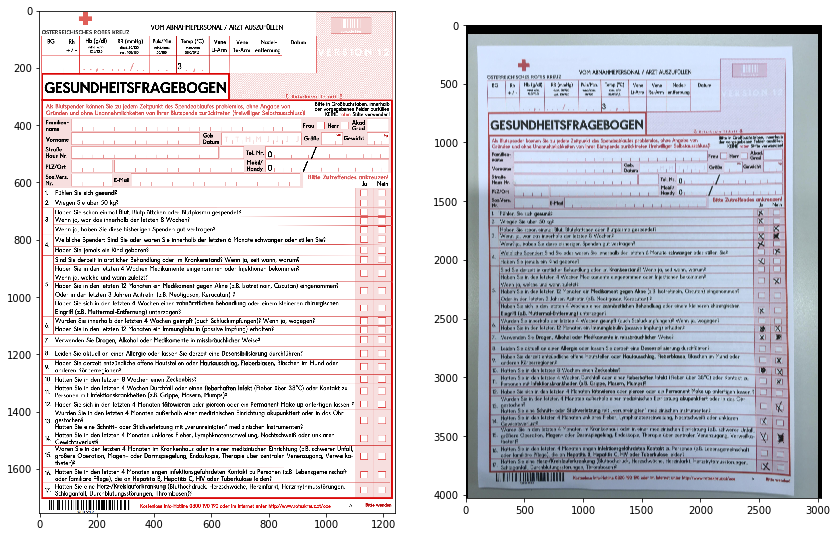

In [8]:
fig, axs = plt.subplots(math.ceil(len(unwarpped_path_list)/2), 2, figsize=(14,10))
result_template_name = max(template_dict, key=template_dict.get)
result_template_path = list(Path(template_dir).glob(result_template_name))
result_template = cv.imread(str(*result_template_path))
axs[0].imshow(cv.cvtColor(result_template, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB))


## Useless Code

threshed_path_list = list(Path('./').glob('threshed*'))
fig, axs = plt.subplots(4, 2, figsize=(14, 40))

for i, threshed_path in enumerate(threshed_path_list):
    threshed_img = cv.imread(str(threshed_path), cv.IMREAD_GRAYSCALE).astype(np.uint8)
    #axs[3, i].imshow(threshed_img, cmap='gray')
    template_path = str(*list(Path(template_dir).glob('template*'+threshed_path.name[-5]+'*g')))
    template = cv.cvtColor(cv.imread(template_path).astype(np.uint8), cv.COLOR_BGR2Lab)
    threshed_template = cv.adaptiveThreshold(template[:,:,0].astype(np.uint8), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
    #axs[3, i].imshow(threshed_template, cmap='gray')
    axs[0, i].imshow(abs(threshed_img-threshed_template), cmap='gray')
    med_blured_template = cv.GaussianBlur(threshed_template, (11, 11), 0).astype(np.float32)
    med_blured_template = cv.medianBlur(threshed_template, 11).astype(np.float32)
    med_blured_img = cv.GaussianBlur(threshed_img, (11, 11), 0).astype(np.float32)
    med_blured_img = cv.medianBlur(threshed_img, 11).astype(np.float32)
    axs[1, i].imshow(abs(med_blured_img-med_blured_template), cmap='gray')
    med_blured_template = cv.GaussianBlur(threshed_template, (11, 11), 0).astype(np.float32)
    med_blured_template = cv.medianBlur(threshed_template, 15).astype(np.float32)
    med_blured_img = cv.GaussianBlur(threshed_img, (11, 11), 0).astype(np.float32)
    med_blured_img = cv.medianBlur(threshed_img, 15).astype(np.float32)
    axs[2, i].imshow(abs(med_blured_img-med_blured_template), cmap='gray')
    med_blured_template = cv.GaussianBlur(threshed_template, (11, 11), 0).astype(np.float32)
    # med_blured_template = cv.medianBlur(threshed_template, 7)
    # med_blured_img = cv.medianBlur(threshed_img, 7)
    med_blured_img = cv.GaussianBlur(threshed_img, (11, 11), 0).astype(np.float32)
    axs[3, i].imshow(abs(med_blured_img-med_blured_template), cmap='gray')